In [1]:
import os
os.chdir("../..")

In [12]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from cids.data import get_SCVIC_Dataset, SCVIC_CIDS_CLASSES
import pickle

# Feature Importance Similarity: Leave-One-Class-Out (10 Seeds, with Exclusions)
This notebook leaves out each class (except those in a manual exclusion list), trains a Random Forest 10 times with different seeds, and compares the left-out class to all others using cosine similarity on the top-N most important features. Results are visualized as a heatmap (mean over seeds).

In [13]:
def convert_ds(ds):
    return (
        np.array([np.concatenate([x[i].numpy().flatten() for i in range(len(x) - 1)]) for x in ds]),
        np.array([y[-1] for y in ds])            
    )

In [14]:
print(SCVIC_CIDS_CLASSES.keys())
# Prepare a dataset with all classes for comparison (fixed for all seeds)
print("Loading test dataset...")
dss = get_SCVIC_Dataset(exclude=None, train=False, validation=False, test=True, random_state=42, network_data=True, host_data=False, host_embeddings=False) 
test_ds = dss["test"]
X_test, y_test = convert_ds(test_ds)

dict_keys(['Benign', 'Bot', 'DoS-SlowHTTPTest', 'DoS-Hulk', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection', 'Infiltration', 'DoS-GoldenEye', 'DoS-Slowloris', 'DDOS-LOIC-HTTP', 'DDOS-LOIC-UDP', 'FTP-BruteForce', 'SSH-Bruteforce', 'DDOS-HOIC'])
Loading test dataset...


In [15]:
n_seeds = 10  # Number of top features to use for similarity
exclude_classes = ['Benign', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection', 'Infiltration']
all_class_names = list(SCVIC_CIDS_CLASSES.keys())
all_classes = list(SCVIC_CIDS_CLASSES.values())

rfs_featureimportance = {}
for exclude_class in all_class_names:
    if exclude_class in exclude_classes:
        continue
    rfs_featureimportance[exclude_class] = []
    print(f"Left out class: {exclude_class}")
    left_out_idx = SCVIC_CIDS_CLASSES[exclude_class]
    similarity_rows = []
    print("loading dataset...")
    train_ds = get_SCVIC_Dataset(exclude=[exclude_class], train=True, validation=True, test=False, random_state=42, network_data=True, host_data=False, host_embeddings=False)["train"]
    X_train, y_train = convert_ds(train_ds)
    y_train = np.astype(y_train != 0, int)
    print("Start training on 10 seeds")
    for seed in range(n_seeds):
        # Train RF
        print(f"Fitting seed {seed}")
        rf = RandomForestClassifier(n_estimators=200, n_jobs=32, random_state=seed)
        rf.fit(X_train, y_train)
        # Get feature importances
        feature_importances = rf.feature_importances_
        rfs_featureimportance[exclude_class].append(feature_importances)
 


Left out class: Bot
loading dataset...
Start training on 10 seeds
Fitting seed 0
Fitting seed 1
Fitting seed 2
Fitting seed 3
Fitting seed 4
Fitting seed 5
Fitting seed 6
Fitting seed 7
Fitting seed 8
Fitting seed 9
Left out class: DoS-SlowHTTPTest
loading dataset...
Start training on 10 seeds
Fitting seed 0
Fitting seed 1
Fitting seed 2
Fitting seed 3
Fitting seed 4
Fitting seed 5
Fitting seed 6
Fitting seed 7
Fitting seed 8
Fitting seed 9
Left out class: DoS-Hulk
loading dataset...
Start training on 10 seeds
Fitting seed 0
Fitting seed 1
Fitting seed 2
Fitting seed 3
Fitting seed 4
Fitting seed 5
Fitting seed 6
Fitting seed 7
Fitting seed 8
Fitting seed 9
Left out class: DoS-GoldenEye
loading dataset...
Start training on 10 seeds
Fitting seed 0
Fitting seed 1
Fitting seed 2
Fitting seed 3
Fitting seed 4
Fitting seed 5
Fitting seed 6
Fitting seed 7
Fitting seed 8
Fitting seed 9
Left out class: DoS-Slowloris
loading dataset...
Start training on 10 seeds
Fitting seed 0
Fitting seed 1
Fi

In [17]:
# After rfs_featureimportance is filled:
with open("results/01_supervision/leaf-x-out-binary/SCVIC/feature_importance.pkl", "wb") as f:
    pickle.dump(rfs_featureimportance, f)
print("Feature importances saved to results/01_supervision/leaf-x-out-binary/SCVIC/feature_importance.pkl")

Feature importances saved to results/01_supervision/leaf-x-out-binary/SCVIC/feature_importance.pkl


Computing similarity for top 5 features
Explained variance: 0.29


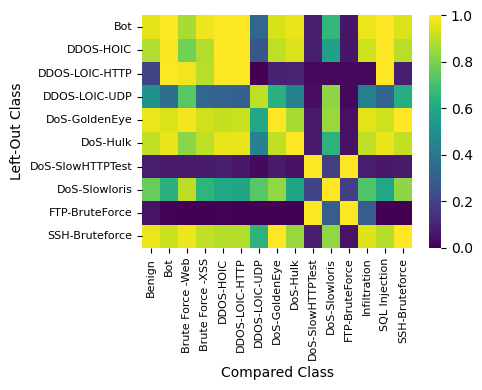

Computing similarity for top 10 features
Explained variance: 0.44


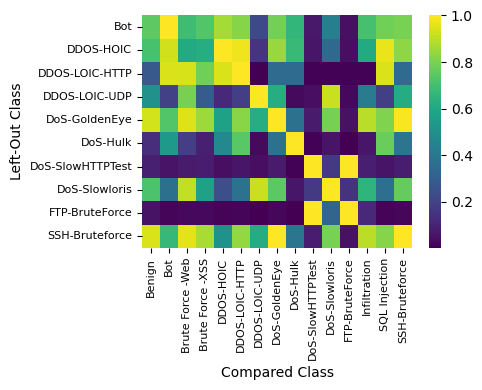

Computing similarity for top 20 features
Explained variance: 0.61


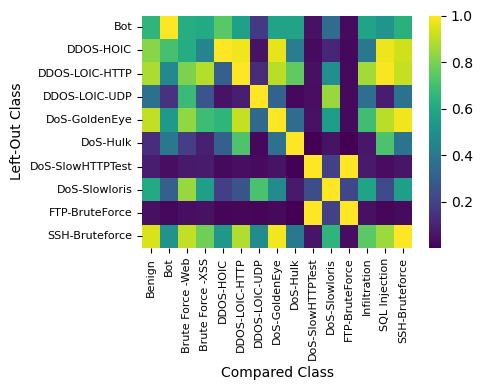

Computing similarity for top 30 features
Explained variance: 0.72


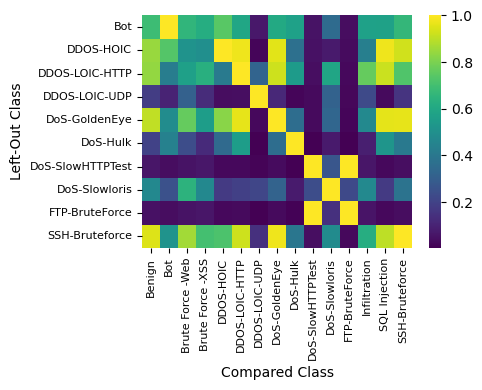

Computing similarity for top 50 features
Explained variance: 0.87


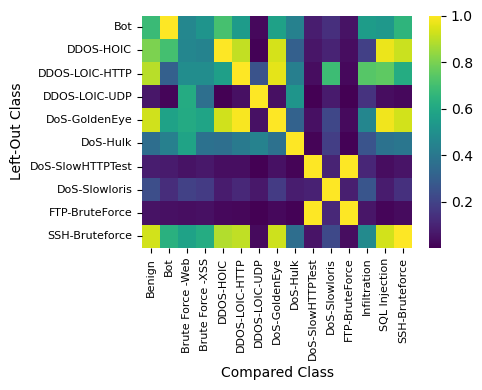

Computing similarity for top 100 features
Explained variance: 1.00


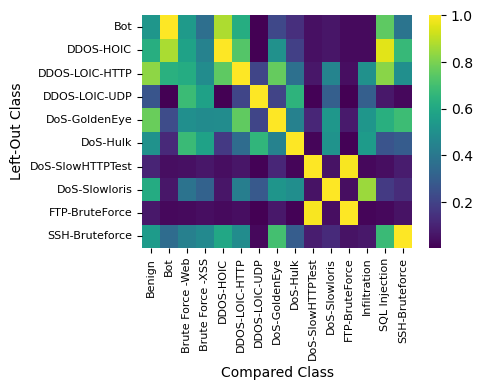

Computing similarity for top 132 features
Explained variance: 1.00


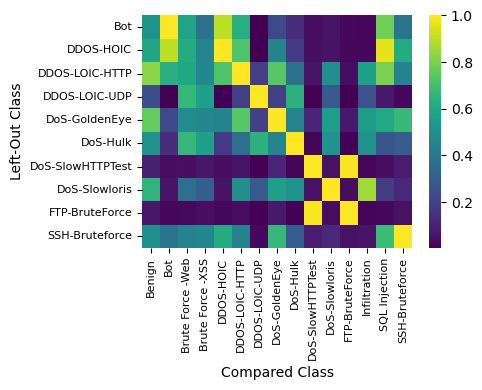

In [61]:

n_top_features_iter = [5, 10, 20, 30, 50, 100, 132]
all_class_names = np.asarray(list(SCVIC_CIDS_CLASSES.keys()))

for n_top_features in n_top_features_iter:
    print(f"Computing similarity for top {n_top_features} features")
    similarity_tensor = []
    left_out_labels = []
    explained = 0
    for exclude_class in all_class_names:
        if exclude_class in exclude_classes:
            continue
        left_out_idx = SCVIC_CIDS_CLASSES[exclude_class]
        similarity_rows = []
        for i, seed in enumerate(range(n_seeds)):
            feature_importances = rfs_featureimportance[exclude_class][i]
            sorted_idx = np.argsort(feature_importances)[::-1]
            top_idx = sorted_idx[:n_top_features]
            explained += np.sum(feature_importances[top_idx])
            # Compute mean feature vector for each class (on top-N features)
            class_feature_means = {}
            for c in all_classes:
                mask = (y_test == c)
                if np.sum(mask) == 0:
                    continue
                class_feature_means[c] = X_test[mask][:, top_idx].mean(axis=0)
            # For left-out class, use the mean of its samples (if available)
            mask = (y_test == left_out_idx)
            if np.sum(mask) == 0:
                similarity_rows.append([np.nan] * len(all_classes))
                continue
            left_out_mean = X_test[mask][:, top_idx].mean(axis=0)
            # Compare to all other classes
            similarity_row = []
            for c in all_classes:
                if c not in class_feature_means:
                    similarity_row.append(np.nan)
                    continue
                sim = cosine_similarity(left_out_mean.reshape(1, -1), class_feature_means[c].reshape(1, -1))[0, 0]
                similarity_row.append(sim)
            similarity_rows.append(similarity_row)
        similarity_tensor.append(similarity_rows)
        left_out_labels.append(exclude_class)
    explained /= (len(all_class_names) - len(exclude_classes)) * n_seeds
    print(f"Explained variance: {explained:.2f}")
    # Convert to array: (n_left_out, n_seeds, n_classes)
    similarity_tensor = np.array(similarity_tensor)
    # Mean over seeds (axis=1)
    similarity_matrix = np.nanmean(similarity_tensor, axis=1)

    sorted_idx = np.argsort(all_class_names)
    left_out_idx = np.argsort(left_out_labels)
    similarity_matrix = similarity_matrix[:, sorted_idx][left_out_idx]
    left_out_labels = np.array(left_out_labels)[left_out_idx]

    # Plot heatmap
    plt.figure(figsize=(5, max(4, 0.36*len(left_out_labels))))

    sns.heatmap(similarity_matrix, annot=False, cmap="viridis",
                xticklabels=all_class_names[sorted_idx], yticklabels=left_out_labels, cbar=True)
    plt.xlabel("Compared Class")
    plt.ylabel("Left-Out Class")
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.savefig(f"plots/cosinsesim_top{n_top_features}.pdf", bbox_inches='tight')
    plt.show()